In [1]:
# %%
import copy
import dnnlib
from torch_utils import misc
from torch_utils.ops import conv2d_gradfix
from torch_utils.ops import grid_sample_gradfix
from networks import legacy
from networks.stylegan2 import Generator as Stylegan2Generator
from networks.stylegan2 import Discriminator as Stylegan2Discriminator
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from time import time
from skimage.io import imread
import cv2
import pickle
from networks.encoders import ResnetEncoder
from networks.FLAME import FLAME, FLAMETex
from networks.decoders import Generator
from utils import util
from utils.rotation_converter import batch_euler2axis
from utils.config import cfg
torch.backends.cudnn.benchmark = True
from utils.renderer import SRenderY
import torch
import torch.nn as nn
# %%
import math
import random
import os
import copy
import pickle
import numpy as np
import torch

import os, sys
import torch
import torchvision
import torch.nn.functional as F

import numpy as np
from time import time
from skimage.io import imread
import cv2
import pickle
from utils.rotation_converter import batch_euler2axis
from utils.tensor_cropper import transform_points
from utils.config import cfg
torch.backends.cudnn.benchmark = True
from torch.utils.data import Dataset, DataLoader
from networks.UVGan import UVGan
from munch import DefaultMunch
import warnings
warnings.filterwarnings('ignore')

import albumentations as albu
import albumentations.pytorch
import logging
from torch.optim.lr_scheduler import MultiStepLR

torch.backends.cudnn.benchmark = True    # Improves training speed.
torch.backends.cuda.matmul.allow_tf32 = False  # Allow PyTorch to internally use tf32 for matmul
torch.backends.cudnn.allow_tf32 = False        # Allow PyTorch to internally use tf32 for convolutions
conv2d_gradfix.enabled = True                       # Improves training speed.
grid_sample_gradfix.enabled = True                  # Avoids errors with the augmentation pipe.



# %%
import copy
import dnnlib
from torch_utils import misc
from torch_utils.ops import conv2d_gradfix
from torch_utils.ops import grid_sample_gradfix
from networks import legacy
from networks.stylegan2 import Generator as Stylegan2Generator
from networks.stylegan2 import Discriminator as Stylegan2Discriminator
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from time import time
from skimage.io import imread
import cv2
import pickle
from networks.encoders import ResnetEncoder
from networks.FLAME import FLAME, FLAMETex
from networks.decoders import Generator
from utils import util
from utils.rotation_converter import batch_euler2axis
from utils.config import cfg
torch.backends.cudnn.benchmark = True
from utils.renderer import SRenderY
import torch
import torch.nn as nn
import torch.autograd
def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(par2[k].data, alpha=1 - decay)


def sample_data(loader):
    while True:
        for batch in loader:
            yield batch


def d_logistic_loss(real_pred, fake_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)

    return real_loss.mean() + fake_loss.mean()


def d_r1_loss(real_pred, real_img):
    with conv2d_gradfix.no_weight_gradients():
        grad_real, = torch.autograd.grad(
            outputs=real_pred.sum(), inputs=real_img, create_graph=True
        )
    grad_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()

    return grad_penalty


def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()

    return loss


def g_path_regularize(fake_img, latents, mean_path_length, decay=0.01):
    noise = torch.randn_like(fake_img) / math.sqrt(
        fake_img.shape[2] * fake_img.shape[3]
    )
    grad, = torch.autograd.grad(
        outputs=(fake_img * noise).sum(), inputs=latents, create_graph=True
    )
    path_lengths = torch.sqrt(grad.pow(2).sum(2).mean(1))

    path_mean = mean_path_length + decay * (path_lengths.mean() - mean_path_length)

    path_penalty = (path_lengths - path_mean).pow(2).mean()

    return path_penalty, path_mean.detach(), path_lengths


def make_noise(batch, latent_dim, device):
    return torch.randn(batch, latent_dim, device=device)




def mixing_noise(batch, latent_dim, prob, device):
    if prob > 0 and random.random() < prob:
        return make_noise(batch, latent_dim, 2, device)

    else:
        return make_noise(batch, latent_dim, 1, device)


def run_G(G, z, c, prob):
    ws = G.mapping(z, c)
    if prob > 0:
        cutoff = torch.empty([], dtype=torch.int64, device=ws.device).random_(1, ws.shape[1])
        cutoff = torch.where(torch.rand([], device=ws.device) < prob, cutoff, torch.full_like(cutoff, ws.shape[1]))
        ws[:, cutoff:] = G.mapping(torch.randn_like(z), c, skip_w_avg_update=True)[:, cutoff:]
    img = G.synthesis(ws)
    return img, ws

def run_D(D, img, c, aug):
    if aug is not None:
        img = aug(img)
    logits = D(img, c)
    return logits

# %%

class Renderer(nn.Module):
    def __init__(self, config=None):
        super().__init__()

        self.cfg = config
        self.device = "cuda:0"
        self.image_size = self.cfg.image_size
        self.image_channels = 3
        self.condition_dim = 0
        self.uv_size = self.cfg.uv_size

        mask = cv2.imread(self.cfg.face_eye_mask_path).astype(np.float32)/255.
        mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_eye_mask = F.interpolate(mask, [self.uv_size, self.uv_size]).to(self.device)

        self._setup_renderer(self.cfg)

    def _setup_renderer(self, cfg):
        self.render = SRenderY(self.image_size, obj_filename=cfg.topology_path, uv_size=cfg.uv_size, rasterizer_type="pytorch3d").to(self.device)
        # face mask for rendering details
        mask = imread(cfg.face_eye_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_eye_mask = F.interpolate(mask, [cfg.uv_size, cfg.uv_size]).to(self.device)
        mask = imread(cfg.face_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_mask = F.interpolate(mask, [cfg.uv_size, cfg.uv_size]).to(self.device)
        # displacement correction
        fixed_dis = np.load(cfg.fixed_displacement_path)
        self.fixed_uv_dis = torch.tensor(fixed_dis).float().to(self.device)
        # dense mesh template, for save detail mesh
        self.dense_template = np.load(cfg.dense_template_path, allow_pickle=True, encoding='latin1').item()        

    def displacement2normal(self, uv_z, coarse_verts, coarse_normals):
        ''' Convert displacement map into detail normal map
        '''
        batch_size = uv_z.shape[0]
        uv_coarse_vertices = self.render.world2uv(coarse_verts).detach()
        uv_coarse_normals = self.render.world2uv(coarse_normals).detach()
    
        uv_z = uv_z*self.uv_face_eye_mask
        uv_detail_vertices = uv_coarse_vertices + uv_z*uv_coarse_normals + self.fixed_uv_dis[None,None,:,:]*uv_coarse_normals.detach()
        dense_vertices = uv_detail_vertices.permute(0,2,3,1).reshape([batch_size, -1, 3])
        uv_detail_normals = util.vertex_normals(dense_vertices, self.render.dense_faces.expand(batch_size, -1, -1))
        uv_detail_normals = uv_detail_normals.reshape([batch_size, uv_coarse_vertices.shape[2], uv_coarse_vertices.shape[3], 3]).permute(0,3,1,2)
        uv_detail_normals = uv_detail_normals*self.uv_face_eye_mask + uv_coarse_normals*(1-self.uv_face_eye_mask)
        return uv_detail_normals


cfg_dict = {
  "device": "cuda:0",
  "topology_path": '/src/deca/DECA/data/head_template.obj',
  'dense_template_path': '/src/deca/DECA/data/texture_data_256.npy',
  'fixed_displacement_path': '/src/deca/DECA/data/fixed_displacement_256.npy',
  'flame_model_path': '/src/deca/DECA/data/generic_model.pkl',
  'flame_lmk_embedding_path': '/src/deca/DECA/data/landmark_embedding.npy',
  'face_mask_path': '/src/deca/DECA/data/uv_face_mask.png',
  'face_eye_mask_path': '/src/deca/DECA/data/uv_face_eye_mask.png',
  'image_size': 256,
  'uv_size' : 256,
}
cfg = DefaultMunch.fromDict(cfg_dict)

renderer = Renderer(cfg)


In [2]:
cfg = DefaultMunch.fromDict(cfg_dict)

renderer = Renderer(cfg)


# %%
device = "cuda:0"
batch_size = 24

# %%

############################
# DECA
############################
cfg_dict = {
  "save_dir" : "./snapshots/snapshot-uv/aligned_snapshot_lpips",
  "device": "cuda:0",
  "random_seed": 0,
  "epochs": 50,
  "DECA_kwargs": {
    "pretrained_model" : '/src/deca/DECA/data/deca_model.tar',
    "topology_path": '/src/deca/DECA/data/head_template.obj',
    'dense_template_path': '/src/deca/DECA/data/texture_data_256.npy',
    'fixed_displacement_path': '/src/deca/DECA/data/fixed_displacement_256.npy',
    'flame_model_path': '/src/deca/DECA/data/generic_model.pkl',
    'flame_lmk_embedding_path': '/src/deca/DECA/data/landmark_embedding.npy',
    'face_mask_path': '/src/deca/DECA/data/uv_face_mask.png',
    'face_eye_mask_path': '/src/deca/DECA/data/uv_face_eye_mask.png',
    'mean_tex_path': '/src/deca/DECA/data/mean_texture.jpg',
    'tex_path': '/src/deca/DECA/data/FLAME_albedo_from_BFM.npz',
    'tex_type': 'BFM',
    'image_size': 224,
    'uv_size': 256,
    'param_list': ['shape', 'tex', 'exp', 'pose', 'cam', 'light'],
    'n_shape': 100,
    'n_tex': 50,
    'n_exp': 50,
    'n_cam': 3,
    'n_pose': 6,
    'n_light': 27,
    'use_tex': True, 
    'jaw_type': 'aa',
    'fr_model_path': '/src/deca/DECA/data/resnet50_ft_weight.pkl', 
    'n_detail': 128, 
    'max_z': 0.01,
    'jaw_type' : 'euler'
  }
}

cfg = DefaultMunch.fromDict(cfg_dict)

# DECA set up parameters
n_shape = cfg.DECA_kwargs.n_shape
n_tex = cfg.DECA_kwargs.n_tex
n_exp = cfg.DECA_kwargs.n_exp
n_pose = cfg.DECA_kwargs.n_pose
n_cam = cfg.DECA_kwargs.n_cam
n_light = cfg.DECA_kwargs.n_light
uv_size = 256
n_detail = cfg.DECA_kwargs.n_detail
n_cond = n_exp + 3 # exp + jaw pose
max_z = cfg.DECA_kwargs.max_z

num_list = [n_shape, n_tex, n_exp, n_pose, n_cam, n_light]
param_dict = {i:cfg.DECA_kwargs.get('n_' + i) for i in cfg.DECA_kwargs.param_list}

# DECA decoders
flame = FLAME(cfg.DECA_kwargs).to(device)
DECA_detail = Generator(latent_dim=n_detail+n_cond, out_channels=1, out_scale=max_z, sample_mode = 'bilinear').to(device)
flametex = FLAMETex(cfg.DECA_kwargs).to(device)

# resume deca model
model_path_deca = cfg.DECA_kwargs.pretrained_model
if os.path.exists(model_path_deca):
    print(f'DECA trained model found. load {model_path_deca}')
    checkpoint = torch.load(model_path_deca)
    checkpoint = checkpoint
    util.copy_state_dict(DECA_detail.state_dict(), checkpoint['D_detail'])
else:
    print(f'DECA trained model not found please check model path: {model_path_deca}')
    
DECA_detail.eval()





creating the FLAME Decoder
DECA trained model found. load /src/deca/DECA/data/deca_model.tar


Generator(
  (l1): Sequential(
    (0): Linear(in_features=181, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=bilinear)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=bilinear)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Upsample(scale_factor=2.0, mode=bilinear)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

In [3]:
###############################
# UV map
###############################
cfg_dict = {
    "pretrained_model" : "/src/current-approach/synthethic-face-generation-and-manipulation/snapshots/snapshot/network-snapshot-11.pkl",
    "img_size" : 256,
    "cond_dim" : 0,
    "channels" : 3,
    "G_kwargs": {
      "z_dim": 50,
      "w_dim": 512,
      "mapping_kwargs": {
        "num_layers": 8
      },
      "synthesis_kwargs": {
        "channel_base": 16384,
        "channel_max": 512,
        "num_fp16_res": 4,
        "conv_clamp": 256
      }
    }
    }

uv_cfg = DefaultMunch.fromDict(cfg_dict)
uv_z_dim = uv_cfg.G_kwargs.z_dim
uv_c_dim = uv_cfg.cond_dim

common_kwargs_uv_G = dict(c_dim=uv_cfg.cond_dim, img_resolution=uv_cfg.img_size, img_channels=uv_cfg.channels)
uv_G = Stylegan2Generator(**uv_cfg.G_kwargs, **common_kwargs_uv_G).requires_grad_(False).to(device) 
uv_G_ema = copy.deepcopy(uv_G).to(device) 
if os.path.exists(uv_cfg.pretrained_model):
    print(f'Stylegan trained model found. load {uv_cfg.pretrained_model}')
    with dnnlib.util.open_url(uv_cfg.pretrained_model) as f:
        resume_data = legacy.load_network_pkl(f)
    for name, module in [('G', uv_G), ('D', None), ('G_ema', uv_G_ema)]:
      if(module is not None):

        misc.copy_params_and_buffers(resume_data[name], module, require_all=False)
else:
    print(f'Stylegan trained model not found found please check model path: {uv_cfg.pretrained_model}')


256 aaaaa
Stylegan trained model found. load /src/current-approach/synthethic-face-generation-and-manipulation/snapshots/snapshot/network-snapshot-11.pkl


In [4]:


###############################
# background
###############################
cfg_dict = {
    "pretrained_model" : "/src/data/models/ffhq-res256-mirror-paper256-noaug.pkl",
    "img_size" : 256,
    "channels" : 3,
    "z_dim": 512,

}

bg_cfg = DefaultMunch.fromDict(cfg_dict)
bg_z_dim = bg_cfg.z_dim
bg_G = Generator(latent_dim=bg_z_dim, out_channels=bg_cfg.channels, out_scale=1, sample_mode = 'bilinear', last_layer_act="lrelu").requires_grad_(True).to(device)



In [5]:


############
# discrim
############


cfg_dict = {
    "pretrained_model" : "",

    "img_size" : 256,
    "cond_dim" : 0,
    "channels" : 3,
    "D_kwargs": {
      "block_kwargs": {},
      "mapping_kwargs": {},
      "epilogue_kwargs": {
        "mbstd_group_size": 8
      },
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    },
}
D_cfg = DefaultMunch.fromDict(cfg_dict)

common_kwargs_D = dict(c_dim=D_cfg.cond_dim, img_resolution=D_cfg.img_size, img_channels=D_cfg.channels)
D = Stylegan2Discriminator(**D_cfg.D_kwargs, **common_kwargs_D).requires_grad_(False).to(device) 

if os.path.exists(D_cfg.pretrained_model):
    print(f'Stylegan trained model found. load {D_cfg.pretrained_model}')
    with dnnlib.util.open_url(D_cfg.pretrained_model) as f:
        resume_data = legacy.load_network_pkl(f)
    for name, module in [('G', None), ('D', D), ('G_ema', None)]:
      if(module is not None):
        misc.copy_params_and_buffers(resume_data[name], module, require_all=False)
else:
    print(f'Stylegan trained model not found found please check model path: {D_cfg.pretrained_model}')


Stylegan trained model not found found please check model path: 


In [6]:



# %%
cfg_dict = {   
    "snapshot_nimg": 30000,
    "ema_kimg": 10,
    "G_opt_kwargs": {
      "lr": 0.001,
      "betas": [
        0,
        0.99
      ],
      "eps": 1e-08
    },
    "D_opt_kwargs": {
      "lr": 0.001,
      "betas": [
        0,
        0.99
      ],
      "eps": 1e-08
    },
}

loss_cfg = DefaultMunch.fromDict(cfg_dict)

bg_G.train().requires_grad_(True)

uv_G.train().requires_grad_(True)
D.train().requires_grad_(True)


params = list(uv_G.parameters()) + list(bg_G.parameters())
optimizer_G = torch.optim.Adam(params, **loss_cfg.G_opt_kwargs)
optimizer_D = torch.optim.Adam(D.parameters(), **loss_cfg.D_opt_kwargs)



# %%


# %%


# %%
n_param = cfg.DECA_kwargs.n_shape+cfg.DECA_kwargs.n_tex+cfg.DECA_kwargs.n_exp+cfg.DECA_kwargs.n_pose+cfg.DECA_kwargs.n_cam+cfg.DECA_kwargs.n_light
print(cfg.DECA_kwargs.n_shape)
print(cfg.DECA_kwargs.n_tex)
print(cfg.DECA_kwargs.n_exp)
print(cfg.DECA_kwargs.n_pose)
print(cfg.DECA_kwargs.n_cam)
print(cfg.DECA_kwargs.n_light)
print(n_param)

# %%
from datasets.pimgan import PIMGANDataset



transforms = albu.Compose([
    albu.LongestMaxSize(max_size=256, always_apply=True),

    albu.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255, always_apply=True, p=1.0),
    albumentations.pytorch.transforms.ToTensorV2()])

dataset = PIMGANDataset("/src/data/raw_data/images1024x1024", transforms)


batch_size = 8
num_workers = 5

train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)


# %%
logging.basicConfig(filename=os.path.join("/src/current-approach/new/snapshots", 'app.log'), filemode='w', format='%(name)s - %(levelname)s - %(message)s', level=logging.DEBUG)


# %%
cfg.save_dir = "/src/current-approach/new/snapshots0"
os.makedirs(cfg.save_dir, exist_ok=True)
logging.basicConfig(filename=os.path.join(cfg.save_dir, 'app.log'), filemode='w', format='%(name)s - %(levelname)s - %(message)s', level=logging.DEBUG)



100
50
50
6
3
27
236


In [7]:
from networks.augment import AugmentPipe
cfg_dict = {
"p" : 0,
"augment_kwargs": {
    "xflip": 1,
    "rotate90": 1,
    "xint": 1,
    "scale": 1,
    "rotate": 1,
    "aniso": 1,
    "xfrac": 1,
    "brightness": 1,
    "contrast": 1,
    "lumaflip": 1,
    "hue": 1,
    "saturation": 1
  },
}
aug_cfg = DefaultMunch.fromDict(cfg_dict)

augment = AugmentPipe(**aug_cfg.augment_kwargs).requires_grad_(False).to(device)
augment.p.copy_(torch.as_tensor(0))


tensor(0., device='cuda:0')

In [8]:

# %%
gen_iters = 3
discrim_iters = 3
epochs = 100
counter = 0

mean_path_length = 0

r1_gammma = 10
mix_prob = 0.9
loss_dict = {}
batch_idx = 0
ada_interval = 4
ada_kimg = 5000
ada_target = 0.6
d_reg_every = 16
g_reg_every  = 4
path_batch_shrink = 2
mean_path_length = 0
mean_path_length_avg = 0
mean_path_length = 0
mean_path_length_avg = 0
accum = 0.5 ** (32 / (10 * 1000))
path_regularize = 2

for epoch in range(epochs):
    print(epoch)
    for i, data in enumerate(train_loader):
        batch_idx = batch_idx + 1

        #############################################################
        ################# Rendering flame model #####################
        #############################################################
        # DECA generation
        dummy_uv = torch.zeros(batch_size, 3, uv_size, uv_size).to(device)

        # shape
        noise_shape = torch.randn(batch_size, n_shape).to(device)

        # exp
        noise_exp = torch.randn(batch_size, n_exp).to(device)

        # pose
        noise_pose = torch.zeros((batch_size, n_pose)).to(device)
        tmp_pose = torch.FloatTensor(batch_size, ).uniform_(-np.pi / 36, np.pi / 36)
        noise_pose[:, 0] = tmp_pose
        tmp_pose = torch.FloatTensor(batch_size, ).uniform_(-np.pi / 8, np.pi / 8)
        noise_pose[:, 1] = tmp_pose
        tmp_pose = torch.FloatTensor(batch_size, ).uniform_(0, np.pi / 15)
        noise_pose[:, 3] = tmp_pose

        # camera
        camera = torch.zeros((batch_size, 3)).to(device)
        tmp_cam_x = torch.FloatTensor(batch_size, ).uniform_(7, 11)#7, 11
        camera[:, 0] = tmp_cam_x

        # detail 
        noise_detail = torch.randn(batch_size, n_detail).to(device)

        # generate 3DMM
        verts, landmarks2d, landmarks3d = flame(shape_params=noise_shape, expression_params=noise_exp, pose_params=noise_pose)

        #rendering
        landmarks2d = util.batch_orth_proj(landmarks2d, camera)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:] #; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2

        # world to camera
        trans_verts = util.batch_orth_proj(verts, camera)
        predicted_landmarks = util.batch_orth_proj(landmarks2d, camera)[:,:,:2]

        # camera to image space
        trans_verts[:,:,1:] = -trans_verts[:,:,1:]
        predicted_landmarks[:,:,1:] = - predicted_landmarks[:,:,1:]

        # rendering
        ops = renderer.render(verts, trans_verts, dummy_uv) 
        visibility_mask = ops["alpha_images"]
        # uv_detail_normals = renderer.displacement2normal(displacement_map, verts, ops['normals'])
        grid = ops['grid']


        # displacement map generation
        with torch.no_grad():
            displacement_map = DECA_detail(torch.cat([noise_pose[:,3:], noise_exp, noise_detail], dim=1))


        # augmentation of images
        real_img = data.to(device)
        real_img = augment(real_img)

        #####################################################
        ################## Discriminator ####################
        #####################################################
        D.zero_grad()

        # background generation
        noise_bg_z = make_noise(batch_size, bg_z_dim, device)
        bg_img = bg_G(noise_bg_z)

        # gen
        noise_uv_z = make_noise(batch_size, uv_z_dim, device)
        noise_uv_c = torch.randn(batch_size, uv_c_dim).to(device)
        uv_map, _ = run_G(uv_G, noise_uv_z, noise_uv_c, mix_prob)
        rasterized_img = F.grid_sample(uv_map, grid, align_corners=False)
        fake_img = rasterized_img * visibility_mask + bg_img * (1-visibility_mask)

        # fakes
        fake_pred = run_D(D, fake_img, torch.zeros(batch_size, uv_c_dim).to(device), None)
        
        # reals
        real_pred = run_D(D, real_img, torch.zeros(batch_size, uv_c_dim).to(device), augment)

        loss_D = d_logistic_loss(real_pred, fake_pred)

        loss_dict["d"] = loss_D
        loss_dict["real_score"] = real_pred.mean()
        loss_dict["fake_score"] = fake_pred.mean()

        loss_D.backward()
        optimizer_D.step()

        # Execute ADA heuristic.
        if (batch_idx % ada_interval == 0):
            adjust = (real_pred.sign().sum() - ada_target).sign() * (batch_size * ada_interval) / (ada_kimg * 1000)
            augment.p.copy_((augment.p + adjust).max(misc.constant(0, device=device)))
            loss_dict["p"] = augment.p + adjust

        # discriminator regularization
        d_regularize = batch_idx % d_reg_every == 0
        if d_regularize:
            D.zero_grad()
            tmp_img = real_img.detach().requires_grad_(True)
            real_pred = run_D(D, tmp_img, torch.zeros(batch_size, uv_c_dim).to(device), augment)
            r1_loss = d_r1_loss(real_pred, tmp_img)
            (r1_gammma / 2 * r1_loss * d_reg_every + 0 * real_pred[0]).backward()
            optimizer_D.step()

            loss_dict["r1"] = r1_loss


        #####################################################
        ################## Generator ####################
        #####################################################


        # background generation
        bg_G.zero_grad()
        uv_G.zero_grad()

        noise_bg_z = make_noise(batch_size, bg_z_dim, device)
        bg_img = bg_G(noise_bg_z)

        # uv map generation
        noise_uv_z = make_noise(batch_size, uv_z_dim, device)
        noise_uv_c = torch.randn(batch_size, uv_c_dim).to(device)
        uv_map, _ = run_G(uv_G, noise_uv_z, noise_uv_c, mix_prob)

        # geherates fake image
        rasterized_img = F.grid_sample(uv_map, grid, align_corners=False)
        fake_img = rasterized_img * visibility_mask + bg_img * (1-visibility_mask)

        fake_pred = run_D(D, fake_img, torch.zeros(batch_size, uv_c_dim).to(device), None)
        loss_G = g_nonsaturating_loss(fake_pred)
        loss_dict["g"] = loss_G
        loss_G.backward()
        optimizer_G.step()


        g_regularize = batch_idx % g_reg_every == 0

        if g_regularize:

            path_batch_size = max(1, batch_size // path_batch_shrink)
            noise_uv_z = make_noise(batch_size, uv_z_dim, device)
            noise_uv_c = torch.randn(batch_size, uv_c_dim).to(device)
            uv_map, uv_ws = run_G(uv_G, noise_uv_z, noise_uv_c, mix_prob)

            path_loss, mean_path_length, path_lengths = g_path_regularize(
                uv_map, uv_ws, mean_path_length
            )

            weighted_path_loss = path_regularize * g_reg_every * path_loss

            if path_batch_shrink:
                weighted_path_loss += 0 * uv_map[0, 0, 0, 0]

            weighted_path_loss.backward()

            optimizer_G.step()
            mean_path_length_avg = (
                mean_path_length / batch_size
            )
            loss_dict["path"] = path_loss
            loss_dict["path_length"] = path_lengths.mean()
        accumulate(uv_G_ema, uv_G, accum)

        if i % 100 == 0:
            torchvision.utils.save_image(torchvision.utils.make_grid(fake_img.detach().cpu()), os.path.join(cfg.save_dir, 'fakes.png'))
            torchvision.utils.save_image(torchvision.utils.make_grid(real_img.detach().cpu()), os.path.join(cfg.save_dir, 'real.png'))
            torchvision.utils.save_image(torchvision.utils.make_grid(uv_map.detach().cpu()), os.path.join(cfg.save_dir, 'uv.png'))
            torchvision.utils.save_image(torchvision.utils.make_grid(bg_img.detach().cpu()), os.path.join(cfg.save_dir, 'bg.png'))
            torchvision.utils.save_image(torchvision.utils.make_grid(visibility_mask.detach().cpu()), os.path.join(cfg.save_dir, 'vis.png'))
            val_str = ""
            for key in loss_dict.keys():
                val_str =  val_str + " " + key + ": " + str(loss_dict[key].item())
            val_str = "batch_idx " + str(batch_idx) + " " +  val_str
            logging.info(val_str)

            
        if(batch_size * batch_idx > 10000):
            torchvision.utils.save_image(torchvision.utils.make_grid(fake_img.detach().cpu()), os.path.join(cfg.save_dir, 'fakes' + str(epoch) +'.png'))
            torchvision.utils.save_image(torchvision.utils.make_grid(real_img.detach().cpu()), os.path.join(cfg.save_dir, 'real' + str(epoch) +'.png'))
            torchvision.utils.save_image(torchvision.utils.make_grid(uv_map.detach().cpu()), os.path.join(cfg.save_dir, 'uv' + str(epoch) +'.png'))
            torchvision.utils.save_image(torchvision.utils.make_grid(bg_img.detach().cpu()), os.path.join(cfg.save_dir, 'bg' + str(epoch) +'.png'))

            snapshot_data = {}
            for name, module in [('G', uv_G), ('D', D), ('G_ema', uv_G_ema)]:
                if module is not None:
                    module = copy.deepcopy(module).eval().requires_grad_(False).cpu()
                snapshot_data[name] = module
                del module # conserve memory
            snapshot_pkl = os.path.join(cfg.save_dir, f'network-snapshot-{batch_size * batch_idx}.pkl')
            with open(snapshot_pkl, 'wb') as f:
                pickle.dump(snapshot_data, f)

            torch.save(bg_G.state_dict(), os.path.join(cfg.save_dir, f'network-snapshot-bg-{batch_size * batch_idx}.pth'))

            

#     snapshot_data = {}
#     for name, module in [('G', uv_G), ('D', D), ('G_ema', uv_G)]:
#         if module is not None:
#             module = copy.deepcopy(module).eval().requires_grad_(False).cpu()
#         snapshot_data[name] = module
#         del module # conserve memory
#     snapshot_pkl = os.path.join(cfg.save_dir, f'network-snapshot-uv-{epoch}.pkl')
#     with open(snapshot_pkl, 'wb') as f:
#         pickle.dump(snapshot_data, f)

# # %%
# torchvision.utils.save_image(torchvision.utils.make_grid(fake_img.detach().cpu()), os.path.join(cfg.save_dir, 'fakes' + str(epoch) +'.png'))
# torchvision.utils.save_image(torchvision.utils.make_grid(real_img.detach().cpu()), os.path.join(cfg.save_dir, 'real' + str(epoch) +'.png'))
# torchvision.utils.save_image(torchvision.utils.make_grid(uv_map.detach().cpu()), os.path.join(cfg.save_dir, 'uv' + str(epoch) +'.png'))
# torchvision.utils.save_image(torchvision.utils.make_grid(bg_img.detach().cpu()), os.path.join(cfg.save_dir, 'bg' + str(epoch) +'.png'))



# # %%
# snapshot_data = {}
# for name, module in [('G', bg_G), ('D', D), ('G_ema', bg_G)]:
#     if module is not None:
#         module = copy.deepcopy(module).eval().requires_grad_(False).cpu()
#     snapshot_data[name] = module
#     del module # conserve memory
# snapshot_pkl = os.path.join(cfg.save_dir, f'network-snapshot-{epoch}.pkl')
# with open(snapshot_pkl, 'wb') as f:
#     pickle.dump(snapshot_data, f)


# # %%


0
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.


KeyboardInterrupt: 

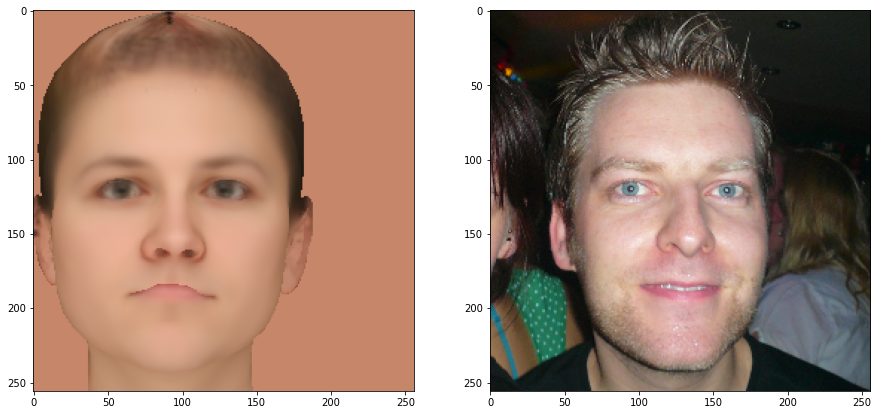

In [11]:
batch_idx = batch_idx + 1

#############################################################
################# Rendering flame model #####################
#############################################################
# DECA generation
dummy_uv = torch.zeros(batch_size, 3, uv_size, uv_size).to(device)

# shape
noise_shape = torch.randn(batch_size, n_shape).to(device)

# exp
noise_exp = torch.randn(batch_size, n_exp).to(device)

# pose
noise_pose = torch.zeros((batch_size, n_pose)).to(device)
tmp_pose = torch.FloatTensor(batch_size, ).uniform_(-np.pi / 36, np.pi / 36)
noise_pose[:, 0] = torch.zeros_like(tmp_pose)
tmp_pose = torch.FloatTensor(batch_size, ).uniform_(-np.pi / 8, np.pi / 8)
noise_pose[:, 1] = torch.zeros_like(tmp_pose)
tmp_pose = torch.FloatTensor(batch_size, ).uniform_(0, np.pi / 15)
noise_pose[:, 3] = torch.zeros_like(tmp_pose)

# camera
camera = torch.zeros((batch_size, 3)).to(device)
tmp_cam_x = torch.FloatTensor(batch_size, ).uniform_(9, 9)#7, 11
camera[:, 0] = tmp_cam_x
camera[:, 2] = torch.FloatTensor(batch_size, ).uniform_(-0.016, -0.016)
camera[:, 1] = torch.FloatTensor(batch_size, ).uniform_(-0.03, -0.03)

# detail 
noise_detail = torch.randn(batch_size, n_detail).to(device)

# generate 3DMM
verts, landmarks2d, landmarks3d = flame(shape_params=noise_shape, expression_params=noise_exp, pose_params=noise_pose)

#rendering
landmarks2d = util.batch_orth_proj(landmarks2d, camera)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:] #; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2

# world to camera
trans_verts = util.batch_orth_proj(verts, camera)
predicted_landmarks = util.batch_orth_proj(landmarks2d, camera)[:,:,:2]

# camera to image space
trans_verts[:,:,1:] = -trans_verts[:,:,1:]
predicted_landmarks[:,:,1:] = - predicted_landmarks[:,:,1:]

albedo = flametex(torch.zeros(batch_size, 50).to(device))
# rendering
ops = renderer.render(verts, trans_verts, albedo) 
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(ops['albedo_images'][3].permute(1, 2, 0).cpu())
plt.subplot(1, 2, 2)
plt.imshow(real_img[4].permute(1, 2, 0).cpu())


In [ ]:
ops.keys()

dict_keys(['albedo_images', 'alpha_images', 'pos_mask', 'shading_images', 'grid', 'normals', 'normal_images', 'transformed_normals'])

import random

In [ ]:
uv_map.max()

tensor(1.4681, device='cuda:0', grad_fn=<MaxBackward1>)